In [1]:
import fiona
import os
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from ipywidgets import HBox, Label, IntSlider,IntRangeSlider
from ipywidgets import HTML
from IPython.display import clear_output
from ipyleaflet import Map, basemaps, basemap_to_tiles, CircleMarker, Popup, Polyline, Polygon, LayerGroup, LayersControl,ScaleControl, FullScreenControl
from ipyleaflet import WidgetControl
from ipywidgets import interactive
import matplotlib as mpl
import ipywidgets as widgets
from ipywidgets import HBox, Label, IntSlider,IntRangeSlider
#import matplotlib.patches as patches
#from matplotlib.patches import Polygon
import matplotlib
import matplotlib.colors
import contextily as cx
import shapely.geometry as sg
from rijksdriehoek import rijksdriehoek
from matplotlib.collections import PatchCollection
import ipympl
import warnings
import numpy as np
import ast
import datetime as dt


RD = rijksdriehoek.Rijksdriehoek()
plt.rcParams.update({'font.size': 24})
MAX_GROUP_SIZE = 250

In [2]:
def read_KNMI_file(filename):
    f = open(filename)
    data = f.read().split('\n')
    f.close()
    start_idx = None
    for i in range(len(data)):
        if '# STN,YYYYMMDD' in data[i]:
            start_idx = i + 2
            break
    headers = data[start_idx-2].split(',')
    headers = [h.strip() for h in headers]
    evapo_id = headers.index('EV24')
    date_id = headers.index('YYYYMMDD')
    precip_id = headers.index('RH')
    temp_id = headers.index('TX')
    processed_data = {}
    for row in data[start_idx:]:
        if row != '':
            split_row = row.split(',')
            date = dt.datetime.strptime(split_row[date_id].strip(), '%Y%m%d')
            if '' not in [date, split_row[evapo_id].strip(), split_row[precip_id].strip(), split_row[temp_id].strip()]:
                if '348' in filename and date.year < 1988: # very incomplete data before 1988
                    continue
                processed_data[date] = [eval(split_row[precip_id].strip()),
                                        eval(split_row[evapo_id].strip()),
                                        eval(split_row[temp_id].strip())]
                if processed_data[date][0] == -1:
                    processed_data[date][0] = 0
                processed_data[date][0] /= 10
                processed_data[date][1] /= 10
                processed_data[date][2] /= 10
    return processed_data

def read_gpkg(filename):
    
    assert '.' in filename, f'Filename {filename} does not have an extension!'    
    if filename.split('.')[1] != 'gpkg':
        raise ValueError(f'Expected gpkg, got {filename}')
    if not os.path.isfile(f'Data/{filename}'):
        raise ValueError(f'File {filename} not found in Data directory!')
    
    AOI = {}
    with fiona.open(f"Data/{filename}") as layer:
        for feature in layer:     
            AOI[feature['properties']['ogc_fid']] = {
                "crd_dec": [feature['geometry']['coordinates'][ii] for ii in range(len(feature['geometry']['coordinates']))]
                }
            for key in ['h0', 's_h0', 'xI', 's_xI', 'xP', 's_xP', 'xE', 's_xE', 'tau', 's_tau',
                        'rho_xIh0', 'rho_xPh0', 'rho_xEh0', 'rho_tauh0',
                        'rho_xPxI', 'rho_xExI', 'rho_xItau', 
                        'rho_xPxE', 'rho_xPtau', 
                        'rho_xEtau', 'xI_frac']:
                AOI[feature['properties']['ogc_fid']][key] = feature['properties'][key]
    return AOI

def convert_wgs84_to_rd(list_of_coords):
    """
    Converts a list of coordinates in WGS84 to RD
    :param list_of_coords: list of (lon, lat) objects
    :return: list of (rd_x, rd_y) objects
    """
    rd_coords = []
    for coord in list_of_coords:
        RD.from_wgs(lon=coord[0], lat=coord[1])
        rd_coords.append([RD.rd_x, RD.rd_y])
    return rd_coords

def convert_rd_to_wgs84(list_of_coords):
    """
    Converts a list of coordinates in RD to WGS
    :param list_of_coords: list of (rdx, rdy) objects
    :return: list of (lon, lat) objects
    """
    wgs_coords = []
    for coord in list_of_coords:
        RD.rd_x = coord[0]
        RD.rd_y = coord[1]
        wgs_coords.append(RD.to_wgs())
    return wgs_coords

def get_yearfrac(date):
    year = eval(date[:4])
    month = eval(date[5:7].lstrip('0'))
    day = eval(date[8:].lstrip('0'))
    dayOfYear = dt.datetime(year=year, month=month, day=day) - dt.datetime(year=year, month=1, day=1)
    yearDays = dt.datetime(year=year+1, month=1, day=1) - dt.datetime(year=year, month=1, day=1)
    yearfrac = year + dayOfYear.days / yearDays.days
    return yearfrac

In [3]:
t0 = '2015-01-02'
Cabauw = read_KNMI_file(f'Data/etmgeg_348.txt')
tmax = max(Cabauw.keys())
tmax = '{:0>4d}-{:0>2d}-{:0>2d}'.format(tmax.year, tmax.month, tmax.day)
tmin = min(Cabauw.keys()) + dt.timedelta(days=365) # to give space for tau to run back
tmin = '{:0>4d}-{:0>2d}-{:0>2d}'.format(tmin.year, tmin.month, tmin.day)
etmgeg = Cabauw 

tmin_yf = get_yearfrac(tmin)
tmax_yf = get_yearfrac(tmax)
t0_yf = get_yearfrac(t0)
t0_dt = dt.datetime.strptime(t0, '%Y-%m-%d')
tmin_dt = dt.datetime.strptime(tmin, '%Y-%m-%d')
tmax_dt = dt.datetime.strptime(tmax, '%Y-%m-%d')

t_eval_min = dt.datetime(1960, 1, 1)

In [4]:
def get_data(file):
    EUP_f = open(f'Data/EUPs/{file}.txt')
    raw = EUP_f.read()
    EUP_f.close()
    raw_EUP = raw.replace('nan', "'nan'").replace('array', 'np.array')
    EUP = eval(raw_EUP)

    if EUP['InSAR'] != -999:
        for keykey in [k for k in EUP['InSAR'].keys() if k[0] == 'h']:
            for d in range(len(EUP['InSAR'][keykey])):
                if EUP['InSAR'][keykey][d] == 'nan':
                    EUP['InSAR'][keykey][d] = np.nan

    
    y = []
    y_insar = []
    t = []
    t_insar = []
    s = []
    s_insar = []
    min_t = None
    max_t = None

    if EUP['EUP_type'] == 'brp':
        for key in ['100_AHN1', '100_AHN2', '100_AHN3', '100_AHN4', '_ThMD']:
            if EUP[f't{key}'] not in [-999, '']:
                y.append(EUP[f'h{key}'])
                t.append(EUP[f't{key}'])
                s.append(max(EUP[f's{key}'], 0.001))

        if EUP['InSAR'] != -999:
            keys = [key[1:] for key in EUP['InSAR'].keys() if key[0] == 't']
            for key in keys:
                for t_ in range(len(EUP['InSAR'][f't{key}'])):
                    if not np.isnan(EUP['InSAR'][f'h{key}'][t_]):
                        t_insar.append(EUP['InSAR'][f't{key}'][t_])
                        y_insar.append(EUP['InSAR'][f'h{key}'][t_])
                        s_insar.append(0.01)

    else:
        for key in ['100_AHN1', '100_AHN2', '100_AHN3', '100_AHN4', '_ThMD']:
            if EUP[f't{key}'] not in [-999, '']:
                y.append(EUP[f'h{key}'])
                t.append(EUP[f't{key}'])
                s.append(EUP[f's{key}'])
    full_y = []
    full_t = []
    full_s = []
    for d in range(len(y)):
        full_y.append(y[d])
        full_t.append(get_yearfrac(t[d]))
        full_s.append(s[d])
    for d in range(len(y_insar)):
        full_y.append(y_insar[d]+EUP['h0'])
        full_t.append(get_yearfrac(t_insar[d]))
        full_s.append(s_insar[d])
    return full_y, full_t, full_s

def plot_model(file):
    EUP_f = open(f'Data/EUPs/{file}.txt')
    raw = EUP_f.read()
    EUP_f.close()
    raw_EUP = raw.replace('nan', "'nan'").replace('array', 'np.array')
    EUP = eval(raw_EUP)

    if EUP['InSAR'] != -999:
        for keykey in [k for k in EUP['InSAR'].keys() if k[0] == 'h']:
            for d in range(len(EUP['InSAR'][keykey])):
                if EUP['InSAR'][keykey][d] == 'nan':
                    EUP['InSAR'][keykey][d] = np.nan
    tt = []
    h = []
    cur_t = t_eval_min
    while get_yearfrac('{:0>4d}-{:0>2d}-{:0>2d}'.format(cur_t.year, cur_t.month, cur_t.day)) < tmax_yf:
        tt.append('{:0>4d}-{:0>2d}-{:0>2d}'.format(cur_t.year, cur_t.month, cur_t.day))
        cur_t += dt.timedelta(days=1)

    xI = EUP['xI']
    xP = EUP['xP']
    xE = EUP['xE']
    h0 = EUP['h0']
    tau = EUP['tau']

    ndays = (tmax_dt-tmin_dt).days

    R_array = np.zeros((ndays, ))
    I_array = np.zeros((ndays, ))
    t_array = np.zeros((ndays, ))
    t0_idx = None

    for day in range(ndays):
        for backwards_day in range(int(tau)+1):
            cur_day = tmin_dt + dt.timedelta(days=day-backwards_day)
            try:
                Pt = etmgeg[cur_day][0]
                Et = etmgeg[cur_day][1]
                if backwards_day == int(tau):
                    R_array[day] += (Pt*xP - Et*xE) * (tau % 1)
                else:
                    R_array[day] += (Pt*xP - Et*xE)

            except KeyError:
                continue

        if R_array[day] <= 0:
            I_array[day] = I_array[day-1] + xI
        else:
            I_array[day] = I_array[day-1]

        date = tmin_dt + dt.timedelta(days=day)
        t_array[day] = get_yearfrac('{:0>4d}-{:0>2d}-{:0>2d}'.format(date.year, date.month, date.day))
        if date == t0_dt:
            t0_idx = day

    t_lst = list(t_array)
    if t0_idx is None:
        raise ValueError('t0 > tmax!')

    xIfrac = sum(1*R_array<=0)/R_array.shape[0]

    R_array -= R_array[t0_idx]
    I_array -= I_array[t0_idx]


    for t in tt:
        if get_yearfrac(t) < tmin_yf:
            elev = h0 + R_array[0] + I_array[0] + (dt.datetime.strptime(t, '%Y-%m-%d') - tmin_dt).days * xI * xIfrac
        else:
            tidx = t_lst.index(get_yearfrac(t))
            elev = h0 + R_array[tidx]+I_array[tidx]
        h.append(elev)

    return [get_yearfrac(t) for t in tt], h

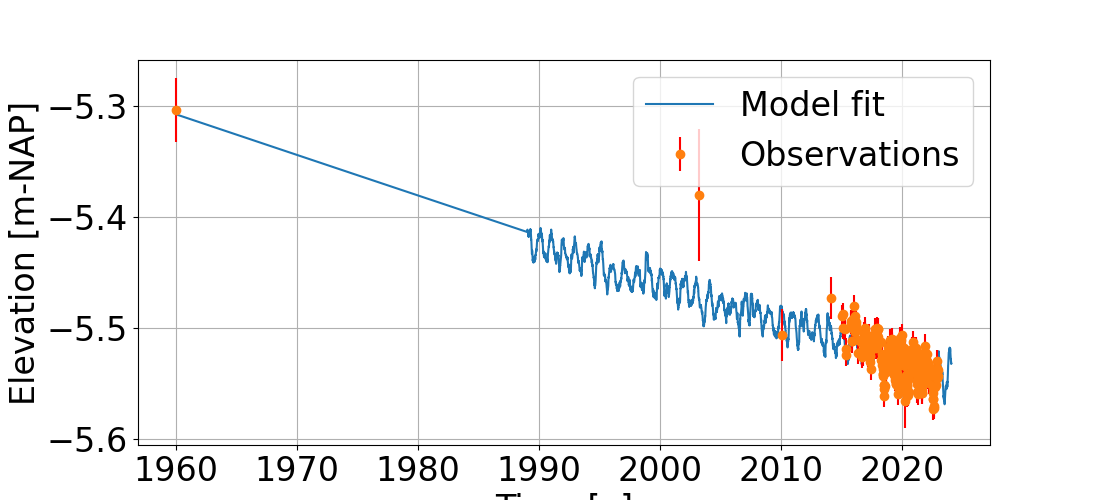

In [5]:
txt_eup = 2000
t, h = plot_model(txt_eup)
y, yt, ys = get_data(txt_eup)
EUP_f = open(f'Data/EUPs/{txt_eup}.txt')
raw = EUP_f.read()
EUP_f.close()
raw_EUP = raw.replace('nan', "'nan'").replace('array', 'np.array')
data = eval(raw_EUP)


plt.figure(figsize=(11,5))
plt.plot(t, h, label='Model fit')
plt.errorbar(yt, y, yerr=ys, fmt='o', ecolor='r', label='Observations')
plt.grid(True)
plt.xlabel('Time [y]')
plt.ylabel('Elevation [m-NAP]')
plt.legend()
plt.show()